In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import os
import sys
import glob
from copy import deepcopy
from astropy.io import fits
from scipy import stats
from scipy.special import erf, erfinv


PROJECT_DIR = '/Users/research/projects/kepler-ecc-rp/'

sys.path.append(PROJECT_DIR)
from utils.stats import weighted_percentile
from utils.io import load_posteriors, extract_posteriors

pi = np.pi

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Load data

In [2]:
#PATH = os.path.join(PROJECT_DIR, 'Results/20241004/injection-test-rp-slices-fwhm10-empirical-gap00/')
PATH = os.path.join(PROJECT_DIR, 'Results/20241007/alderaan-all-LC-rp-slices-fwhm20-empirical/')
#PATH = os.path.join(PROJECT_DIR, 'Results/20241007/alderaan-all-LC-rp10-slices-fwhm10-empirical/')

# pull data from files
files = list(np.sort(glob.glob(os.path.join(PATH, '*.fits'))))

samples, headers, bin_edges = load_posteriors(files)
rp, ecc, mult, nobj = extract_posteriors(samples, headers)


# pull distribution identifier
DIST = headers[0]['DIST']
        
# pull radius type identifier
RAD_TYPE = headers[0]['RAD_TYPE']

In [3]:
DO_PLOT = False
if DO_PLOT:
    for i, s in enumerate(samples):
        bin_centers = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])

        ln_pdf = s.filter(regex='ln_pdf')
        ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)

        pdf = np.exp(np.percentile(ln_pdf, [16,50,84], axis=0))
        mu = np.percentile(ecc[i], [16,50,84])

    
        fig, ax = plt.subplots(1,2, figsize=(8,3))

        ax[0].plot(bin_centers, pdf[1], c='k')
        ax[0].fill_between(bin_centers, pdf[0], pdf[2], color='grey', alpha=0.3)
        ax[0].axvline(mu[0], color='r', ls=':')
        ax[0].axvline(mu[1], color='r', ls='--')
        ax[0].axvline(mu[2], color='r', ls=':')
        ax[0].set_xlim(0,1)
        ax[0].set_yticks([])
        ax[0].set_xlabel("eccentricity")
        ax[0].set_ylabel("pdf")

        ax[1].hist(ecc[i], color='lightgrey', bins=np.linspace(0,0.5,51))
        ax[1].hist(ecc[i], color='k', histtype='step', bins=np.linspace(0,0.5,51))
        ax[1].set_xlim(0,1)
        ax[1].set_yticks([])
        ax[1].set_xlabel("mean eccentricity")
        ax[1].set_ylabel("density")

        plt.title("{0}, {1}".format(mult[i], rp[i]))
        plt.show()

## $R_p - \langle e \rangle$ relationship

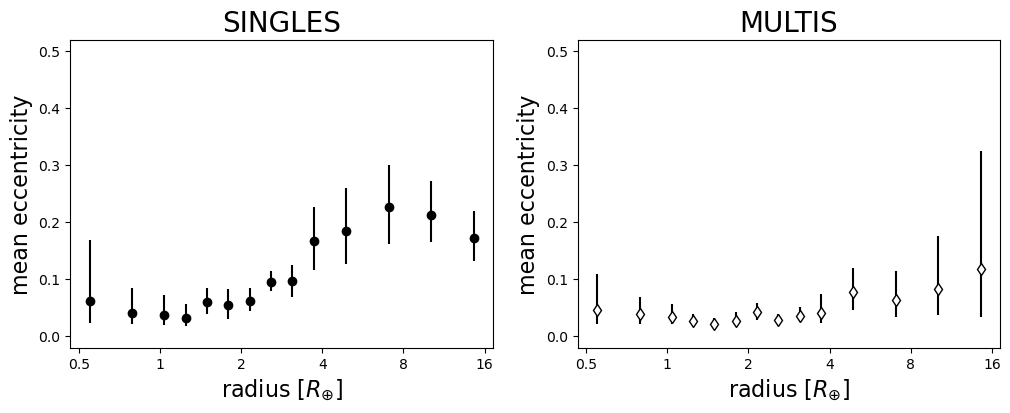

In [4]:
ecc = np.percentile(ecc, [16,50,84], axis=1).T

fig, ax = plt.subplots(1,2, figsize=(12,4))

yerr = np.abs(ecc[mult==1][:,(0,2)].T - ecc[mult==1][:,1])
ax[0].errorbar(np.mean(rp[mult==1], axis=1), ecc[mult==1][:,1], yerr=yerr, fmt='ko')
ax[0].set_xscale('log')
ax[0].set_xticks([0.5,1,2,4,8,16], [0.5,1,2,4,8,16])
ax[0].set_ylim(-0.02,0.52)
ax[0].set_xlabel("radius [$R_{\oplus}$]", fontsize=16)
ax[0].set_ylabel("mean eccentricity", fontsize=16)
ax[0].set_title("SINGLES", fontsize=20)
ax[0].minorticks_off()

yerr = np.abs(ecc[mult==99][:,(0,2)].T - ecc[mult==99][:,1])
ax[1].errorbar(np.mean(rp[mult==99], axis=1), ecc[mult==99][:,1], yerr=yerr, fmt='kd', mfc='w')
ax[1].set_xscale('log')
ax[1].set_xticks([0.5,1,2,4,8,16], [0.5,1,2,4,8,16])
ax[1].set_ylim(-0.02,0.52)
ax[1].set_xlabel("radius [$R_{\oplus}$]", fontsize=16)
ax[1].set_ylabel("mean eccentricity", fontsize=16)
ax[1].set_title("MULTIS", fontsize=20)
ax[1].minorticks_off()

plt.show()

### Fit a model to the data

In [5]:
import aesara_theano_fallback.tensor as T
from   aesara_theano_fallback import aesara as theano
import pymc3 as pm
import pymc3_ext as pmx
import corner

In [6]:
def sigmoid(x, L, k, x0):
    return L/(1+T.exp(-k*(x-x0)))

def gaussian(x, A, m, s):
    return A*T.exp(-(x-m)**2/(2*s**2))

In [7]:
USE_COV = False

#### Singles

In [8]:
# fit in {log(R), e}
x = np.mean(np.log(rp[mult==1]), axis=1)
y = 0.5*(ecc[mult==1][:,2]+ecc[mult==1][:,0])
yerr = 0.5*(ecc[mult==1][:,2]-ecc[mult==1][:,0])

cov = np.diag(yerr**2) + 0.14*np.diag(yerr[:-1]*yerr[1:],1) + 0.14*np.diag(yerr[:-1]*yerr[1:],-1)
icov = np.linalg.inv(cov)

x_pred = np.log(np.linspace(0.5,16.5,500))
rp_pred = np.exp(x_pred)


if RAD_TYPE == 'rp':
    with pm.Model() as model:
        # high and low eccentricity
        B     = pm.Uniform("B", lower=0, upper=1, testval=0.05)
        L_int = pm.Uniform("L_int", lower=0, upper=1, testval=0.1)
        L     = pm.Deterministic("L", L_int*(1-B))

        e_low = pm.Deterministic("e_low", B)
        e_high = pm.Deterministic("e_high", B+L)

        # sigmoid transition
        k = pm.Bound(pm.HalfCauchy, upper=50)("k", beta=25, testval=5)
        x0 = pm.Uniform("x0", lower=np.log(2), upper=np.log(6), testval=np.log(4))
        R0 = pm.Deterministic("R0", T.exp(x0))

        # build the function
        y_mod = pm.Deterministic("y_mod", B + sigmoid(x, L, k, x0))
        y_pred = pm.Deterministic("y_pred",  B + sigmoid(x_pred, L, k, x0))

        if USE_COV:
            obs = pm.MvNormal("obs", mu=y_mod, cov=cov, observed=y)
        else:
            obs = pm.Normal("obs", mu=y_mod, sd=yerr, observed=y)
            
            
if RAD_TYPE == 'rp10':
    with pm.Model() as model:
        # high and low eccentricity
        B = pm.HalfNormal("B",sd=0.5, shape=3, testval=0.03*np.ones(3))
        A = pm.Uniform("A", lower=-1, upper=1, testval=0.05)

        e_low = pm.Deterministic("e_low", B)
        e_high = pm.Deterministic("e_high", B+A)

        # sigmoid transition
        m = pm.Bound(pm.Normal, lower=np.log(1), upper=np.log(4))("m", mu=np.log(1.84), sd=0.1)
        s = pm.Bound(pm.HalfNormal, lower=0.05, upper=0.2)("s", sd=0.05)
        R0 = pm.Deterministic("R0", T.exp(m))

        # build the function
        y_mod = pm.Deterministic("y_mod", B[0] + B[1]*x + B[2]*x**2 + gaussian(x, A, m, s))
        y_pred = pm.Deterministic("y_pred",  B[0] + B[1]*x_pred + B[2]*x_pred**2 + gaussian(x_pred, A, m, s))

        if USE_COV:
            obs = pm.MvNormal("obs", mu=y_mod, cov=cov, observed=y)
        else:
            obs = pm.Normal("obs", mu=y_mod, sd=yerr, observed=y)

In [9]:
with model:
    trace_singles = pmx.optimize(start=model.test_point)
    trace_singles = pmx.sample(tune=10000, draws=1000, chains=2, target_accept=0.95, return_inferencedata=True, start=trace_singles)

optimizing logp for variables: [x0, k, L_int, B]


message: Optimization terminated successfully.
logp: 20.2334734070851 -> 26.373752961401422
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [x0, k, L_int, B]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 22 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8827760389843474, but should be close to 0.95. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8678933417303022, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effect

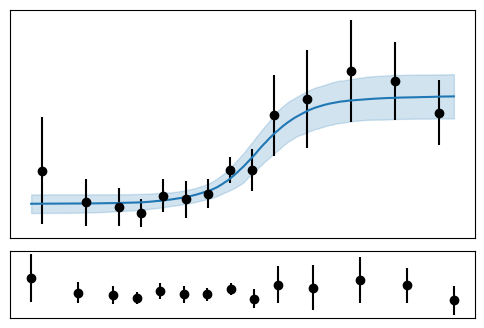

In [10]:
y_mod = np.percentile(trace_singles.posterior.y_mod.values, [16,50,84], axis=(0,1))
y_pred = np.percentile(trace_singles.posterior.y_pred.values, [16,50,84], axis=(0,1))

plt.figure(figsize=(6,4))

ax = plt.subplot2grid(shape=(4,1), loc=(0,0), rowspan=3, colspan=1)
ax.errorbar(x, y, yerr=yerr, fmt='ko')
ax.plot(x_pred, y_pred[1], 'C0')
ax.fill_between(x_pred, y_pred[0], y_pred[2], color='C0', alpha=0.2)
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot2grid(shape=(4,1), loc=(3,0), rowspan=31, colspan=1)
ax.errorbar(x, y-y_mod[1], yerr=yerr, fmt='ko')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

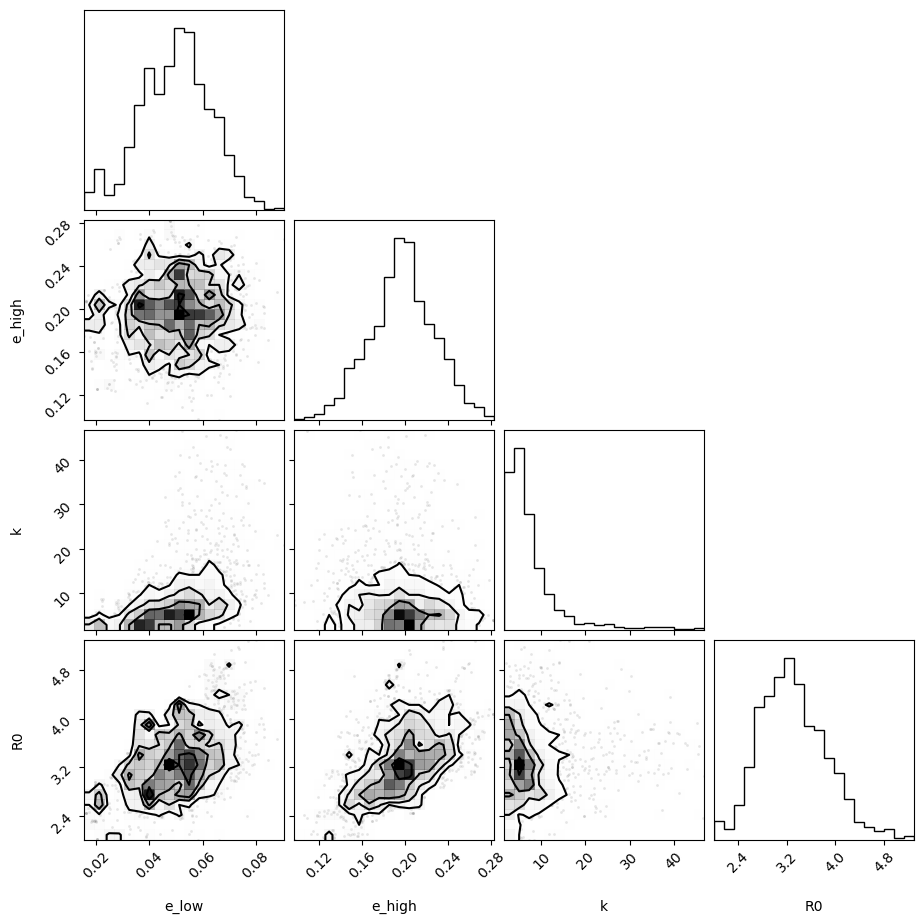

In [11]:
if RAD_TYPE == 'rp':
    _ = corner.corner(trace_singles, var_names=["e_low", "e_high", "k", "R0"])
if RAD_TYPE == 'rp10':
    _ = corner.corner(trace_singles, var_names=["A", "s", "R0"])

In [12]:
if RAD_TYPE == 'rp10':
    A = trace_singles.posterior.A.values.flatten()
    f_pos = np.sum(A > 0)/len(A)
    
    sigma = np.sqrt(2)*erfinv(f_pos)
    
    print("{0:.1f}% of samples consistent with a positive peak ({1:.2f}-sigma)".format(100*f_pos, sigma))

#### Multis

In [13]:
# fit in {log(R), e}
x = np.mean(np.log(rp[mult==99]), axis=1)
y = 0.5*(ecc[mult==99][:,2]+ecc[mult==99][:,0])
yerr = 0.5*(ecc[mult==99][:,2]-ecc[mult==99][:,0])

cov = np.diag(yerr**2) + 0.25*np.diag(yerr[:-1]*yerr[1:],1) + 0.25*np.diag(yerr[:-1]*yerr[1:],-1)
icov = np.linalg.inv(cov)

# prediction vectors for plotting
x_pred = np.log(np.linspace(0.5,16.5,500))
rp_pred = np.exp(x_pred)


if RAD_TYPE == 'rp':
    with pm.Model() as model:
        # high and low eccentricity
        B     = pm.Uniform("B", lower=0, upper=1, testval=0.02)
        L_int = pm.Uniform("L_int", lower=0, upper=1, testval=0.05)
        L     = pm.Deterministic("L", L_int*(1-B))

        e_low = pm.Deterministic("e_low", B)
        e_high = pm.Deterministic("e_high", B+L)

        # sigmoid transition
        k = pm.Uniform("k", lower=0, upper=1000)
        x0 = pm.Uniform("x0", lower=np.log(2), upper=np.log(6), testval=np.log(4))
        R0 = pm.Deterministic("R0", T.exp(x0))    

        # build the function
        y_mod = pm.Deterministic("y_mod", B + sigmoid(x, L, k, x0))
        y_pred = pm.Deterministic("y_pred",  B + sigmoid(x_pred, L, k, x0))

        if USE_COV:
            obs = pm.MvNormal("obs", mu=y_mod, cov=cov, observed=y)
        else:
            obs = pm.Normal("obs", mu=y_mod, sd=yerr, observed=y)
        

if RAD_TYPE == 'rp10':
    with pm.Model() as model:
        # high and low eccentricity
        B = pm.Uniform("B", lower=0, upper=1, shape=3, testval=0.03*np.ones(1))
        A = pm.Uniform("A", lower=-1, upper=1, testval=0.05)

        e_low = pm.Deterministic("e_low", B)
        e_high = pm.Deterministic("e_high", B+A)

        # gaussian peak
        m = pm.Bound(pm.Normal, lower=np.log(1), upper=np.log(4))("m", mu=np.log(1.84), sd=0.1)
        s = pm.Bound(pm.HalfNormal, lower=0.05, upper=0.2)("s", sd=0.05)
        R0 = pm.Deterministic("R0", T.exp(m))

        # build the function
        y_mod = pm.Deterministic("y_mod", B[0] + gaussian(x, A, m, s))
        y_pred = pm.Deterministic("y_pred",  B[0] + gaussian(x_pred, A, m, s))

        if USE_COV:
            obs = pm.MvNormal("obs", mu=y_mod, cov=cov, observed=y)
        else:
            obs = pm.Normal("obs", mu=y_mod[:-1], sd=yerr[:-1], observed=y[:-1])

In [14]:
with model:
    trace_multis = pmx.sample(tune=10000, draws=1000, chains=2, target_accept=0.95, return_inferencedata=True, start=model.test_point)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [x0, k, L_int, B]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 29 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


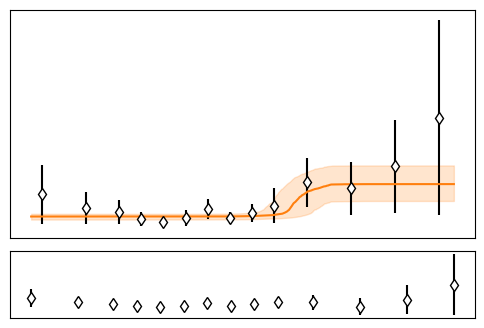

In [15]:
y_mod = np.percentile(trace_multis.posterior.y_mod.values, [16,50,84], axis=(0,1))
y_pred = np.percentile(trace_multis.posterior.y_pred.values, [16,50,84], axis=(0,1))

plt.figure(figsize=(6,4))

ax = plt.subplot2grid(shape=(4,1), loc=(0,0), rowspan=3, colspan=1)
ax.errorbar(x, y, yerr=yerr, fmt='kd', mfc='w')
ax.plot(x_pred, y_pred[1], 'C1')
ax.fill_between(x_pred, y_pred[0], y_pred[2], color='C1', alpha=0.2)
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot2grid(shape=(4,1), loc=(3,0), rowspan=31, colspan=1)
ax.errorbar(x, y-y_mod[1], yerr=yerr, fmt='kd', mfc='w')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

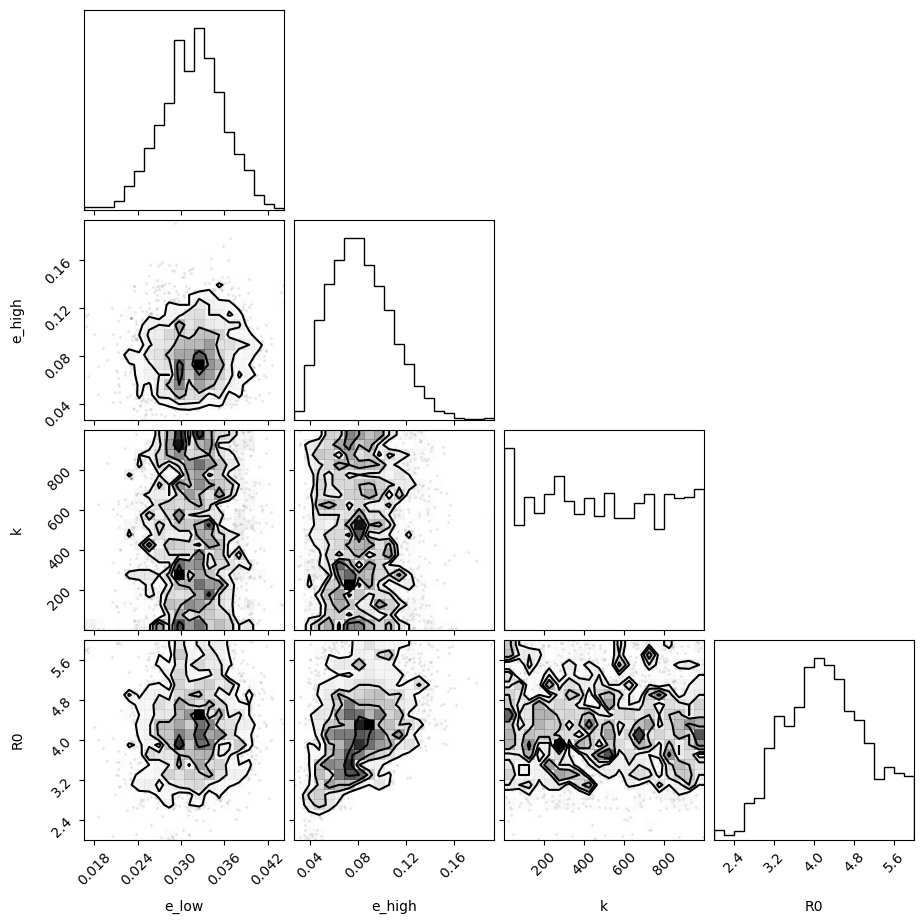

In [16]:
if RAD_TYPE == 'rp':
    _ = corner.corner(trace_multis, var_names=["e_low", "e_high", "k", "R0"])
if RAD_TYPE == 'rp10':
    _ = corner.corner(trace_multis, var_names=["A", "s", "R0"])

In [17]:
if RAD_TYPE == 'rp10':
    A = trace_multis.posterior.A.values.flatten()
    
    f_pos = np.sum(A > 0)/len(A)
    sigma = np.sqrt(2)*erfinv(f_pos)
    
    print("{0:.1f}% of samples consistent with a positive peak ({1:.2f}-sigma)".format(100*f_pos, sigma))

In [ ]:
f_combo = 1-(1-0.728)*(1-0.886)
s_combo = np.sqrt(2)*erfinv(f_combo)

f_combo, s_combo

### Combined plot

In [ ]:
ecc_pred_singles = np.percentile(trace_singles.posterior.y_pred, [16,50,84], axis=(1,0))
ecc_pred_multis = np.percentile(trace_multis.posterior.y_pred, [16,50,84], axis=(1,0))

fig, ax = plt.subplots(2,1, figsize=(6,8))

yerr = np.abs(ecc[mult==1][:,(0,2)].T - ecc[mult==1][:,1])
ax[0].plot(rp_pred, ecc_pred_singles[1], 'C0', lw=2)
ax[0].fill_between(rp_pred, ecc_pred_singles[0], ecc_pred_singles[2], color='C0', alpha=0.2)
ax[0].errorbar(np.mean(rp[mult==1], axis=1), ecc[mult==1][:,1], yerr=yerr, fmt='ko', mfc='k')
ax[0].text(0.03,0.9, "Kepler Singles", color='C0', fontsize=16, transform=ax[0].transAxes)

if RAD_TYPE == 'rp':
    ax[0].set_xlim(0.5, 16)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.5,1,2,4,8,16], [], fontsize=12)

if RAD_TYPE == 'rp10':
    ax[0].set_xlim(1,4)
    ax[0].set_xscale('log')
    ax[0].set_xticks([1,2,3,4], [1,2,3,4], fontsize=12)
    
ax[0].set_ylabel(r"$\langle e \rangle$", fontsize=20)
ax[0].set_ylim(0,0.3)
ax[0].set_yticks([0.0,0.1,0.2,0.3], [0.0,0.1,0.2,0.3], fontsize=12)
ax[0].minorticks_off()

yerr = np.abs(ecc[mult==99][:,(0,2)].T - ecc[mult==99][:,1])
ax[1].plot(rp_pred, ecc_pred_multis[1], 'C1', lw=2)
ax[1].fill_between(rp_pred, ecc_pred_multis[0], ecc_pred_multis[2], color='C1', alpha=0.2)
ax[1].errorbar(np.mean(rp[mult==99], axis=1), ecc[mult==99][:,1], yerr=yerr, fmt='kd', mfc='w')
ax[1].text(0.03,0.9, "Kepler Multis", color='C1', fontsize=16, transform=ax[1].transAxes)

if RAD_TYPE == 'rp':
    ax[1].set_xlim(0.5, 16)
    ax[1].set_xscale('log')
    ax[1].set_xticks([0.5,1,2,4,8,16], [], fontsize=12)
    ax[1].set_xlabel("$R_p$ ($R_{\oplus}$)", fontsize=20)
    
if RAD_TYPE == 'rp10':
    ax[1].set_xlim(1,4)
    ax[1].set_xscale('log')
    ax[1].set_xticks([1,2,3,4], [1,2,3,4], fontsize=12)
    ax[1].set_xlabel("adjusted radus ($R_{\oplus}$)", fontsize=16)    
    
ax[1].set_ylabel(r"$\langle e \rangle$", fontsize=20)
ax[1].set_ylim(0,0.3)
ax[1].set_yticks([0.0,0.1,0.2,0.3], [0.0,0.1,0.2,0.3], fontsize=12)
ax[1].minorticks_off()

plt.tight_layout()
if RAD_TYPE == 'rp':
    plt.savefig(os.path.join(PROJECT_DIR, 'Figures/ecc-rp-{0}.pdf'.format(DIST)), bbox_inches='tight')
if RAD_TYPE == 'rp10':
    plt.savefig(os.path.join(PROJECT_DIR, 'Figures/ecc-rp10-radius-gap-{0}.pdf'.format(DIST)), bbox_inches='tight')
plt.show()

In [ ]:
ecc_pred_singles = np.percentile(trace_singles.posterior.y_pred, [16,50,84], axis=(1,0))
ecc_pred_multis = np.percentile(trace_multis.posterior.y_pred, [16,50,84], axis=(1,0))

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax = [ax]

yerr = np.abs(ecc[mult==1][:,(0,2)].T - ecc[mult==1][:,1])
ax[0].plot(rp_pred, ecc_pred_singles[1], 'C0', lw=2)
ax[0].fill_between(rp_pred, ecc_pred_singles[0], ecc_pred_singles[2], color='C0', alpha=0.2)
ax[0].errorbar(np.mean(rp[mult==1], axis=1), ecc[mult==1][:,1], yerr=yerr, fmt='ko', mfc='k', label='singles')

yerr = np.abs(ecc[mult==99][:,(0,2)].T - ecc[mult==99][:,1])
ax[0].plot(rp_pred, ecc_pred_multis[1], 'C1', lw=2)
ax[0].fill_between(rp_pred, ecc_pred_multis[0], ecc_pred_multis[2], color='C1', alpha=0.2)
ax[0].errorbar(np.mean(rp[mult==99], axis=1), ecc[mult==99][:,1], yerr=yerr, fmt='kd', mfc='w', label='multis')

if RAD_TYPE == 'rp':
    ax[0].set_xlim(0.5, 16)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.5,1,2,4,8,16], [], fontsize=12)

if RAD_TYPE == 'rp10':
    ax[0].set_xlim(1,4)
    ax[0].set_xscale('log')
    ax[0].set_xticks([1,2,3,4], [1,2,3,4], fontsize=12)

if RAD_TYPE == 'rp':
    ax[0].set_xlabel("$R_p$ ($R_{\oplus}$)", fontsize=20)
if RAD_TYPE == 'rp10':
    ax[0].set_xlabel("adjusted radus ($R_{\oplus}$)", fontsize=16)

ax[0].set_ylabel(r"$\langle e \rangle$", fontsize=20)
ax[0].set_ylim(0,0.3)
ax[0].set_yticks([0.0,0.1,0.2,0.3], [0.0,0.1,0.2,0.3], fontsize=12)
ax[0].minorticks_off()

plt.legend()
plt.tight_layout()
if RAD_TYPE == 'rp':
    plt.savefig(os.path.join(PROJECT_DIR, 'Figures/ecc-rp-overlay-{0}.pdf'.format(DIST)), bbox_inches='tight')
if RAD_TYPE == 'rp10':
    plt.savefig(os.path.join(PROJECT_DIR, 'Figures/ecc-rp10-radius-gap-overlay-{0}.pdf'.format(DIST)), bbox_inches='tight')
plt.show()

In [ ]:
if RAD_TYPE == 'rp':
    ecc_pred_singles = np.percentile(trace_singles.posterior.y_pred, [16,50,84], axis=(1,0))
    ecc_pred_multis = np.percentile(trace_multis.posterior.y_pred, [16,50,84], axis=(1,0))

    scale = np.median(ecc_pred_singles[1]/ecc_pred_multis[1])

    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax = [ax]

    yerr = np.abs(ecc[mult==1][:,(0,2)].T - ecc[mult==1][:,1])
    ax[0].plot(rp_pred, ecc_pred_singles[1], 'C0', lw=2, label='singles')
    ax[0].fill_between(rp_pred, ecc_pred_singles[0], ecc_pred_singles[2], color='C0', alpha=0.2)
    ax[0].errorbar(np.mean(rp[mult==1], axis=1), ecc[mult==1][:,1], yerr=yerr, fmt='ko', mfc='k', label='singles', zorder=99)

    yerr = np.abs(ecc[mult==99][:,(0,2)].T - ecc[mult==99][:,1])
    ax[0].plot(rp_pred, scale*ecc_pred_multis[1], 'C1', lw=2, label='multis')
    ax[0].fill_between(rp_pred, scale*ecc_pred_multis[0], scale*ecc_pred_multis[2], color='C1', alpha=0.2)
    #ax[0].errorbar(np.mean(rp[mult==1], axis=1), scale*ecc[mult==99][:,1], yerr=yerr, fmt='kd', mfc='w', label='multis', zorder=99)

    ax[0].text(0.55, 0.36, "{0:.2f}x".format(scale), fontsize=12)
    ax[0].set_xlim(0.5, 16)
    ax[0].set_xscale('log')
    ax[0].set_xticks([0.5,1,2,4,8,16], [0.5,1,2,4,8,16], fontsize=12)
    ax[0].set_xlabel("$R_p$ ($R_{\oplus}$)", fontsize=20)
    ax[0].set_ylabel(r"$\langle e \rangle$", fontsize=20)
    ax[0].set_ylim(0,0.4)
    ax[0].set_yticks([0.0,0.1,0.2,0.3,0.4], [0.0,0.1,0.2,0.3,0.4], fontsize=12)
    ax[0].minorticks_off()

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_DIR, 'Figures/ecc-rp-scaled-{0}.pdf'.format(DIST)), bbox_inches='tight')
    plt.show()

### Export data to .csv

In [ ]:
# singles
singles = pd.DataFrame()
singles['rp'] = np.mean(rp[mult==1], axis=1)
singles['ecc_16'] = ecc[mult==1][:,0]
singles['ecc_50'] = ecc[mult==1][:,1]
singles['ecc_84'] = ecc[mult==1][:,2]
singles['mod_16'] = np.percentile(trace_singles.posterior.y_mod, 16, axis=(1,0))
singles['mod_50'] = np.percentile(trace_singles.posterior.y_mod, 50, axis=(1,0))
singles['mod_84'] = np.percentile(trace_singles.posterior.y_mod, 84, axis=(1,0))
singles.to_csv(os.path.join(PROJECT_DIR, "Results/ecc-rp-singles-{0}.csv".format(dist)))

singles = pd.DataFrame()
singles['xpred'] = x_pred
singles['ypred_16'] = np.percentile(trace_singles.posterior.y_pred, 16, axis=(1,0))
singles['ypred_50'] = np.percentile(trace_singles.posterior.y_pred, 50, axis=(1,0))
singles['ypred_84'] = np.percentile(trace_singles.posterior.y_pred, 84, axis=(1,0))
singles.to_csv(os.path.join(PROJECT_DIR, "Results/ecc-rp-singles-smooth-model-{0}.csv".format(dist)))

### Quantify differences between singles and multis

#### low to high $e$ transition location

In [18]:
R0_s = np.percentile(trace_singles.posterior.R0.values, [16,50,84], axis=(0,1))
R0_m = np.percentile(trace_multis.posterior.R0.values, [16,50,84], axis=(0,1))

print("singles: {0:.2f} + {1:.2f} - {2:.2f}".format(R0_s[1], R0_s[2]-R0_s[1], R0_s[1]-R0_s[0]))
print("multis:  {0:.2f} + {1:.2f} - {2:.2f}".format(R0_m[1], R0_m[2]-R0_m[1], R0_m[1]-R0_m[0]))

singles: 3.25 + 0.60 - 0.48
multis:  4.22 + 0.91 - 0.86


#### feature amplitudes

In [30]:
# singles
print("SINGLES")
e_low = trace_singles.posterior.e_low.values.flatten()
e_high = trace_singles.posterior.e_high.values.flatten()

ratio = np.percentile(e_high/e_low, [0,16,50,84])
error = ((ratio[3]-ratio[2]), (ratio[2]-ratio[1]))
thresh = ratio[0]

print(" high/low: {0:.2f} + {1:.2f} - {2:.2f} ({3:.2f})".format(ratio[2], error[0], error[1], ratio[0]))

print("")

_e = np.percentile(e_low, [16,50,84])
print(" low:  {0:.2f} + {1:.2f} - {2:.2f}".format(_e[1], _e[2]-_e[1], _e[1]-_e[0]))

_e = np.percentile(e_high, [16,50,84])
print(" high: {0:.2f} + {1:.2f} - {2:.2f}".format(_e[1], _e[2]-_e[1], _e[1]-_e[0]))

SINGLES
 high/low: 3.94 + 1.63 - 0.96 (1.46)

 low:  0.05 + 0.01 - 0.01
 high: 0.20 + 0.03 - 0.03


In [20]:
# multis
print("MULTIS")
e_low = trace_multis.posterior.e_low.values.flatten()
e_high = trace_multis.posterior.e_high.values.flatten()

ratio = np.percentile(e_high/e_low, [0,16,50,84])
error = ((ratio[3]-ratio[2]), (ratio[2]-ratio[1]))
frac = np.sum(e_high/e_low > thresh)/len(e_high)

print(" high/low: {0:.2f} + {1:.2f} - {2:.2f} ({3:.2f})".format(ratio[2], error[0], error[1], ratio[0]))
print(" {0:.1f}% of multis have enhancement above single minimum value {1:.2f}".format(frac*100, thresh))

MULTIS
 high/low: 2.52 + 1.02 - 0.78 (1.02)
 93.5% of multis have enhancement above single minimum value 1.46


In [21]:

print(np.percentile(e_low, [16,50,84]).round(3))
print(np.percentile(e_high, [16,50,84]))

[0.02733654 0.03186701 0.03588183]
[0.055122   0.08015705 0.10808062]


#### single vs multi $e$ enhancement

In [ ]:
ecc_pred_singles = trace_singles.posterior.y_pred.values
ecc_pred_multis = trace_multis.posterior.y_pred.values

ratio = ecc_pred_singles/ecc_pred_multis
ratio = ratio.reshape(-1,ratio.shape[-1])

x = rp_pred
y = np.percentile(ratio, [16,50,84], axis=0)
z = np.percentile(ratio, [16,50,84])

fig, ax = plt.subplots(1,1, figsize=(6,3))

ax.plot(x, y[1])
ax.fill_between(x, y[0], y[2], alpha=0.3)
ax.set_xlim(1, 16)
ax.set_xscale('log')
ax.set_xticks([1,2,4,8,16], [1,2,4,8,16])
ax.axvline(1.5, color='C1')
ax.axvline(6, color='C1')

plt.xlabel("radius")
plt.ylabel("e_singles/e_multis")
plt.show()

print("singles/multis: {0:.2f} + {1:.2f} - {2:.2f}".format(z[1], z[2]-z[1], z[1]-z[0]))

In [ ]:
# small planets
r = ratio[:,rp_pred < 1.5]
z = np.percentile(r, [16,50,84])

print("small planets: {0:.2f} + {1:.2f} - {2:.2f}".format(z[1], z[2]-z[1], z[1]-z[0]))

In [ ]:
# small planets
r = ratio[:,rp_pred > 6.0]
z = np.percentile(r, [16,50,84])

print("large planets: {0:.2f} + {1:.2f} - {2:.2f}".format(z[1], z[2]-z[1], z[1]-z[0]))

In [ ]:
# intermediate planets
r = ratio[:,(rp_pred > 1.5)*(rp_pred < 6.0)]
z = np.percentile(r, [2.5,16,50,84,97.5])

z.round(2)

In [ ]:
np.median(ecc_pred_singles, axis=(0,1))[0]

In [ ]:
np.median(ecc_pred_multis, axis=(0,1))[0]